# Import Libraries

In [1]:
import uproot
import time
import infofile

import numpy as np
import pandas as pd
import mplhep as hep
import uproot_methods.classes.TLorentzVector as LVepm
import matplotlib.pyplot as plt

from numpy import pi, sqrt, sin, cos, linspace, zeros, arctan, exp, tan, arccos
from scipy import stats

from numpy import array as arr
from numpy import append as app

print('import success')

import success


# Useful Functions

In [2]:
# determine net simulation weight
def get_xsec_weight(sample):
    info = infofile.infos[sample]
    xsec_weight = (lumi*1000*info['xsec'])/(info['sumw']*info['red_eff'])
    return xsec_weight

# File Names and Directories

In [3]:
# monte-carlo simulation data
mc_files = ['mc_361106.Zee.4lep.root',
            'mc_361107.Zmumu.4lep.root',
            'mc_410000.ttbar_lep.4lep.root',
            'mc_363490.llll.4lep.root',
            'mc_363492.llvv.4lep.root',
            'mc_363356.ZqqZll.4lep.root',    
            'mc_345060.ggH125_ZZ4lep.4lep.root',
            'mc_341964.WH125_ZZ4lep.4lep.root',
            'mc_344235.VBFH125_ZZ4lep.4lep.root',
            'mc_341947.ZH125_ZZ4lep.4lep.root']

# actual data
data_files = ['data_A.4lep.root',
              'data_B.4lep.root',
              'data_C.4lep.root',
              'data_D.4lep.root']

# add directory to file names
mc_files = ['4lep/MC/' + file_name for file_name in mc_files]
data_files = ['4lep/Data/' + file_name for file_name in data_files]

# bring 'em all together
directories = mc_files + data_files

# Global Variables

In [4]:
# luminosity (fb) and bin number
lumi = 10
nBins = 34

# mass range, in GeV
h_min, h_max = 80, 250

btagWP77 = 0.6459
zPDG = 91188

# Read Into Dataframe

In [5]:
def read_file(file):
    btagWP77 = 0.6459
    
    name = file.split('.')[1] 
    # sample_names.append(name)
    Type = file.split('/')[1]
    tree = uproot.open(file)['mini']
    
    names = ['mcWeight', 'SumWeights', 'XSection', 'trigM', 'trigE', 'scaleFactor_PILEUP', 
             'scaleFactor_ELE', 'scaleFactor_MUON', 'scaleFactor_LepTRIGGER', 'lep_type', 
             'lep_pt', 'lep_eta', 'lep_phi', 'lep_E', 'lep_charge', 'lep_etcone20', 
             'lep_ptcone30', 'jet_n', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_E', 'jet_MV2c10']
    
    # get info from tree
    (mcWeight, SumWeights, XSection, trigM, trigE, scaleFactor_PILEUP, scaleFactor_ELE, 
    scaleFactor_MUON,scaleFactor_LepTRIGGER, lep_type, lep_pt, lep_eta, lep_phi, lep_E, 
    lep_charge, lep_etcone20, lep_ptcone30, jet_n, jet_pt, jet_eta, jet_phi, jet_E, 
    jet_MV2c10) = tree.arrays(names, outputtype=tuple)
    
    
    leplv = LVepm.TLorentzVectorArray.from_ptetaphi(lep_pt, lep_eta, lep_phi, lep_E)

    lep_reliso_pt = (lep_ptcone30 / lep_pt)
    lep_reliso_et = (lep_etcone20 / lep_pt)
    sum_lep_type = lep_type.sum()
    
    jetlv = LVepm.TLorentzVectorArray.from_ptetaphi(jet_pt, jet_eta, jet_phi, jet_E)
    jetlv = jetlv[jet_MV2c10.argsort()]    
    tags = jet_pt[jet_MV2c10 > btagWP77]
    
    cuts = {'trig_cut': ( (trigM == 1) | (trigE == 1) ), 
            'lep_pt_cut': ( (lep_pt.max() > 20000) & (lep_pt.min() > 7000) ), 
            'lep_eta_cut': ( (lep_eta.min() >- 2.5) & (lep_eta.max() < 2.5) ), 
            'lep_type_cut': ( (sum_lep_type == 44) | (sum_lep_type == 48) | (sum_lep_type == 52) ),
            'lep_iso_cut': ( (lep_reliso_pt.max() < 0.3) & (lep_reliso_pt.max() < 0.3) ),
            'lept_count_cut': ( leplv.counts == 4 ),
            'lept_charge_cut': ( lep_charge.sum()== 0 )}
    
    cut = True
    for boolean in cuts.values():
        cut &= boolean
    
    if True:
        (mcWeight, SumWeights, XSection, trigM, trigE, scaleFactor_PILEUP, scaleFactor_ELE, 
        scaleFactor_MUON,scaleFactor_LepTRIGGER, lep_type, lep_pt, lep_eta, lep_phi, lep_E, 
        lep_charge, lep_etcone20, lep_ptcone30, jet_n, jet_pt, jet_eta, jet_phi, jet_E, 
        jet_MV2c10) = (mcWeight[cut], SumWeights[cut], XSection[cut], trigM[cut], trigE[cut], 
                       scaleFactor_PILEUP[cut], scaleFactor_ELE[cut], scaleFactor_MUON[cut], 
                       scaleFactor_LepTRIGGER[cut], lep_type[cut], lep_pt[cut], lep_eta[cut], 
                       lep_phi[cut], lep_E[cut], lep_charge[cut], lep_etcone20[cut], 
                       lep_ptcone30[cut], jet_n[cut], jet_pt[cut], jet_eta[cut], jet_phi[cut], 
                       jet_E[cut], jet_MV2c10[cut])
    
    if(Type == 'MC'):
        a1 = get_xsec_weight(name)*(mcWeight)*(scaleFactor_PILEUP)
        a2 = (scaleFactor_ELE)*(scaleFactor_MUON)*(scaleFactor_LepTRIGGER)
        finalWeight = a1*a2
    else:
        finalWeight = np.ones(len(lep_type))
        
    df = (mcWeight, SumWeights, XSection, trigM, trigE, scaleFactor_PILEUP, scaleFactor_ELE, 
          scaleFactor_MUON,scaleFactor_LepTRIGGER, lep_type, lep_pt, lep_eta, lep_phi, lep_E, 
          lep_charge, lep_etcone20, lep_ptcone30, jet_n, jet_pt, jet_eta, jet_phi, jet_E, 
          jet_MV2c10, lep_type.sum(), finalWeight)
    
    names = ['mcWeight', 'SumWeights', 'XSec', 'trigM', 'trigE', 'SF_PILEUP', 'SF_ELE', 'SF_MUON', 
             'SF_LepTRIGGER', 'lep_type', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_E', 'lep_charge', 
             'lep_etcone20', 'lep_ptcone30', 'jet_n', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_E', 
             'jet_MV2c10', 'sum_lep_type', 'w']

    df = pd.DataFrame( dict( zip(names, df) ) )
    
    if True:
        df.drop(labels=['mcWeight', 'SumWeights', 'XSec', 'trigM', 'trigE', 'SF_PILEUP', 'SF_ELE', 
                       'SF_MUON', 'SF_LepTRIGGER', 'jet_n', 'jet_pt', 'jet_eta', 'jet_phi', 
                        'jet_E', 'jet_MV2c10'], axis=1, inplace=True)
    
    return df

frames = [read_file(file) for file in directories]
DF = pd.concat(frames)

i = linspace(0, len(DF)-1, len(DF))
DF.set_index(keys=i, inplace=True)
DF['id'] = i

d = {'lep_type': 'type', 'lep_pt': 'pt', 'lep_eta': 'eta', 'lep_phi': 'phi', 'lep_E': 'E',
    'lep_charge': 'Q', 'lep_etcone20': 'etc20', 'lep_ptcone30': 'ptc30'}

DF = DF.rename(mapper=d, axis=1, inplace=False)
DF.drop(labels=['etc20', 'ptc30'], axis=1, inplace=True)

DF

,type,pt,eta,phi,E,Q,sum_lep_type,w,id
0.0,"[11, 11, 11, 11]","[47592.39, 43458.098, 10026.11, 7162.6626]","[-0.8090483, -0.6145289, 2.0875025, 0.6384636]","[-2.2826285, 0.6541073, 0.18135798, 0.8925741]","[64036.78, 51925.496, 41050.63, 8672.812]","[-1, 1, -1, 1]",44,0.169451,0.0
1.0,"[11, 11, 13, 13]","[51710.316, 30980.805, 11872.697, 7892.9395]","[2.211758, 1.0357504, -1.5491847, -0.49692452]","[3.0596266, -0.21164392, -0.018451305, 2.6533346]","[238934.31, 49138.336, 29207.332, 8888.304]","[-1, 1, -1, 1]",48,0.174886,1.0
2.0,"[11, 11, 11, 11]","[65519.844, 17793.098, 14570.528, 7871.123]","[-1.8400015, 0.014194325, 0.10441768, 0.54491776]","[0.4868397, -2.3558335, -1.6149002, -2.8749647]","[211477.25, 17794.89, 14650.032, 9068.935]","[-1, -1, 1, 1]",44,0.381443,2.0
3.0,"[11, 11, 13, 13]","[39427.957, 32687.89, 8821.469, 8123.534]","[0.6319882, -0.72217596, 0.5735928, -0.06887347]","[2.225151, -1.306289, 1.8235722, -1.0468655]","[47567.492, 41588.848, 10313.406, 8143.4946]","[-1, 1, 1, -1]",48,0.166324,3.0
4.0,"[11, 11, 13, 13]","[49097.43, 18737.934, 11769.221, 7947.696]","[-1.0622535, 0.8695862, -1.5491946, -0.4963608]","[2.2721536, -1.0716466, -0.018504394, 2.653314]","[79502.45, 26280.404, 28953.041, 8947.64]","[1, -1, -1, 1]",48,0.156882,4.0
...,...,...,...,...,...,...,...,...,...
818086.0,"[11, 11, 11, 11]","[51773.375, 51708.45, 51148.297, 30737.582]","[-1.28635, -1.0202633, -0.80568916, 0.30312154]","[1.1772112, -1.047273, -1.4184802, 2.3813634]","[100850.09, 81038.13, 68667.06, 32160.553]","[-1, 1, 1, -1]",44,1.000000,818086.0
818087.0,"[13, 13, 13, 13]","[61561.816, 25231.277, 21982.31, 14411.031]","[-0.6561884, -0.043175437, 0.49340436, -0.2145...","[3.0332172, 1.3050667, 0.06840056, 2.7004883]","[75298.086, 25255.02, 24713.037, 14744.3125]","[1, -1, -1, 1]",52,1.000000,818087.0
818088.0,"[13, 13, 13, 13]","[53048.145, 39838.145, 23835.697, 7428.501]","[1.6669953, 1.2820495, 0.009336205, 1.5172257]","[1.6207898, -1.2548615, -2.9835243, -0.25539052]","[145485.73, 77315.69, 23836.97, 17750.264]","[-1, 1, 1, -1]",52,1.000000,818088.0
818089.0,"[11, 11, 11, 11]","[114072.234, 113360.6, 64472.6, 26180.354]","[1.6677951, 1.1956723, 1.5933089, 1.2851827]","[0.0551456, 3.0626664, -0.9325686, -1.999637]","[313078.7, 204518.39, 165154.75, 50946.03]","[1, 1, -1, -1]",44,1.000000,818089.0


# Functions for 4-Lep Analysis

In [6]:
# function to split dataframe into 4, only for eeuu
def split(DATAFRAME):
    df = DATAFRAME
    cols = [col for col in df.columns]

    s = ( len(df), len(cols) )
    A, B, C, D = zeros( shape=s ), zeros( shape=s ), zeros( shape=s ), zeros( shape=s )

    for i, row in enumerate(df.iloc):
        x = np.stack( row[:-2].to_numpy() )
        x_id = row[-1]
        x_weight = row[-2]
        
        x_add = arr([x_weight, x_id])
        
        # ab: electrons, cd: muons
        a, b = tuple(np.where(x[cols.index('type')] == 11)[0])
        c, d = tuple(np.where(x[cols.index('type')] == 13)[0])
        
        x = np.transpose(x)
        A[i], B[i] = app(x[a], x_add), app(x[b], x_add)
        C[i], D[i] = app(x[c], x_add), app(x[d], x_add)
    
    # returns a list with 4 dataframes
    return [ cart(pd.DataFrame(dic, columns=cols)) for dic in [A, B, C, D] ]

# split function for eeee or uuuu, partners lepton's to prioritize Z-mass for single pair
def partner(DATAFRAME):
    df = DATAFRAME
    cols = [col for col in df.columns]

    # create containers for initial split, lower-case to avoid confusion with final split
    s = ( len(df), len(cols) )
    a, b, c, d = zeros( shape=s ), zeros( shape=s ), zeros( shape=s ), zeros( shape=s )

    for i, row in enumerate(df.iloc):
        x = np.stack( row[:-2].to_numpy() )
        x_id = row[-1]
        x_weight = row[-2]
        
        x_add = arr([x_weight, x_id])
        
        # ab: electrons (muons), cd: positrons (antimuons)
        ai, bi = tuple(np.where(x[cols.index('Q')] == -1)[0])
        ci, di = tuple(np.where(x[cols.index('Q')] == 1)[0])
        
        x = np.transpose(x)
        a[i], b[i] = app(x[ai], x_add), app(x[bi], x_add)
        c[i], d[i] = app(x[ci], x_add), app(x[di], x_add)
    
    # pass into mass_compare function to get a boolean sorter
    L4 = [ cart( pd.DataFrame(dic, columns=cols) ) for dic in [a, b, c, d] ]
    cols = L4[0].columns
    sorter = mass_compare(L4)
    
    # add sorter to each array
    for df in L4:
        df['s'] = sorter
        
    # get lepton dataframes such that A partners with B, C partners with D
    A = pd.concat( [ L4[0][sorter == True], L4[1][sorter == False]  ] )
    B = pd.concat( [ L4[2][sorter == True], L4[3][sorter == False]  ] )
    C = pd.concat( [ L4[1][sorter == True], L4[0][sorter == False]  ] )
    D = pd.concat( [ L4[3][sorter == True], L4[2][sorter == False]  ] )
    
    out = [A, B, C, D]
    
    # order dataframes, such that they align, and drop sorter column
    for df in out:
        df.sort_values(by='id', axis=0, inplace=True)
        df.drop(labels=['s'], axis=1, inplace=True)
    
    return out

# replace ptetaphi with cartesian coordinates
def cart(df):
    theta = 2*arctan( exp( -df['eta'] ) )
    df['px'] = df['pt'] * sin( df['phi'] )
    df['py'] = df['pt'] * cos( df['phi'] )
    df['pz'] = df['pt'] / tan(theta)
    df['p'] = sqrt( df['px']**2 + df['py']**2 + df['pz']**2 )
    df.drop(labels=['pt', 'eta', 'phi'], axis=1, inplace=True)
    return df

# Merge and Mass, a generalized function, either LLLL -> ZZ, or ZZ -> H 
def MnM(LIST):
    # if input is LLLL, return ZZ
    if len(LIST) == 4:
        LIST = [df.drop(labels=['p'], axis=1, inplace=False) for df in LIST]
        X, Y = LIST[0] + LIST[1], LIST[2] + LIST[3]
        X['id'], Y['id'] = X['id']/2, Y['id']/2
        X['w'], Y['w'] = X['w']/2, Y['w']/2

        frames = []
        for i, df in enumerate( [X, Y] ):
            df['p'] = sqrt( df['px']**2 + df['py']**2 + df['pz']**2 )
            df['m'] = sqrt( df['E']**2 - df['p']**2 )
            frames.append( df )

        return frames
    
    # if input is ZZ, return H
    elif len(LIST) == 2:
        df = LIST[0] + LIST[1]
        df['id'] = df['id']/2
        df['w'] = df['w']/2
        df.drop(labels=['p'], axis=1, inplace=True)
        if 'm' in df.columns:
            df.drop(labels=['m'], axis=1, inplace=True)
        df['p'] = sqrt( df['px']**2 + df['py']**2 + df['pz']**2 )
        df['m'] = sqrt( df['E']**2 - df['p']**2 )
        return df

# a function to compare 4 leptons and return a series of booleans
def mass_compare(LIST):
    LIST = [ df[ ['E', 'px', 'py', 'pz'] ] for df in LIST ]
    
    # assume input is [a, b, c, d], then this list gives the matching which we test
    names = ['ac', 'ad', 'bc', 'bd']
    LIST = [ LIST[0] + LIST[2], 
             LIST[0] + LIST[3], 
             LIST[1] + LIST[2], 
             LIST[1] + LIST[3] ]
    
    # calculate Z-mass diff for each of the above combinations
    dic = {}
    for i, df in enumerate(LIST):
        dic[names[i]] = abs( sqrt( df['E']**2 - df['px']**2 - df['py']**2 - df['pz']**2 ) - zPDG )
    df = pd.DataFrame(dic)
    
    # if ac then bd, and we only need 1 Z-boson close to 91 GeV
    df['ac'] = df[ ['ad', 'bd'] ].min(axis=1)
    df['ad'] = df[ ['ad', 'bc'] ].min(axis=1)
    df.drop(labels=['bd', 'bc'], axis=1, inplace=True)
    
    # return sorted array, (ac, bd) = True, (ad, bc) = False
    return df['ac'] <= df['ad']

# momentum dot product between 2 particles
def dot(df1, df2):
    return df1['px']*df2['px'] + df1['py']*df2['py'] + df1['pz']*df2['pz']

# get angles between lepton and Z-boson, as well as angle between Z and higgs
def get_angles(llll, zz, h):
    # dict for mapping lep to z
    L2Z = {0: 0, 1: 0, 2: 1, 3: 1}
    
    # 'a' for angle :)
    for i, l in enumerate(llll):
        z = zz[ L2Z[i] ]
        l['a'] = arccos( dot(l, z) / (l['p']*z['p']) )
    for i, z in enumerate(zz):
        z['a'] = arccos( dot(z, h) / (h['p']*z['p']) )
    
    return llll, zz, h
        
# merge all the levels into a single dataframe
def merge(llll, zz, h):
    
    # rename and merge leptons
    for i, df in enumerate(llll):
        df.sort_values(by='id', axis=0, inplace=True)
        df.drop(labels=['id'], axis=1, inplace=True)
        df.drop(labels=['w'], axis=1, inplace=True)
        dic = [f'L{i} '+col for col in df.columns]
        dic = dict( zip(df.columns, dic) )
        df.rename(mapper=dic, axis=1, inplace=True)
    llll = pd.concat(llll, axis=1)
    
    # rename and merge Z's
    for i, df in enumerate(zz):
        df.sort_values(by='id', axis=0, inplace=True)
        df.drop(labels=['id'], axis=1, inplace=True)
        df.drop(labels=['w'], axis=1, inplace=True)
        dic = [f'Z{i} '+col for col in df.columns]
        dic = dict( zip(df.columns, dic) )
        df.rename(mapper=dic, axis=1, inplace=True)
    zz = pd.concat(zz, axis=1)
    
    h.sort_values(by='id', axis=0, inplace=True)
    out = pd.concat([llll, zz, h], axis=1)
    return out

# Split Data and Get Angles

In [7]:
typesum = [52, 44, 48]

def pipeline(DF):
    leps = [DF[DF['sum_lep_type']==ts].drop(labels=['sum_lep_type'], 
                                            axis=1, 
                                            inplace=False) for ts in typesum]

    frames = []
    for i, lep in enumerate(leps):

        # split and match leptons
        if typesum[i] == 48:
            llll = split(lep)
        else:
            llll = partner(lep)

        # get Z's and higgs
        zz = MnM(llll)
        h = MnM(zz)

        # append to list of dataframes
        frames.append( merge( *get_angles(llll, zz, h) ) )

    df = pd.concat(frames, axis=0)
    df.sort_values(by='id', axis=0, inplace=True)
    df.set_index(keys='id', drop=True, inplace=True)
    df.to_csv('DataFrame.csv')
    
    return df

V = pipeline(DF)

In [12]:
V = pd.read_csv('DataFrame.csv')
sim = V[V['w'] != 1]
dat = V[V['w'] == 1]

# Angle Plots

<IPython.core.display.Javascript object>


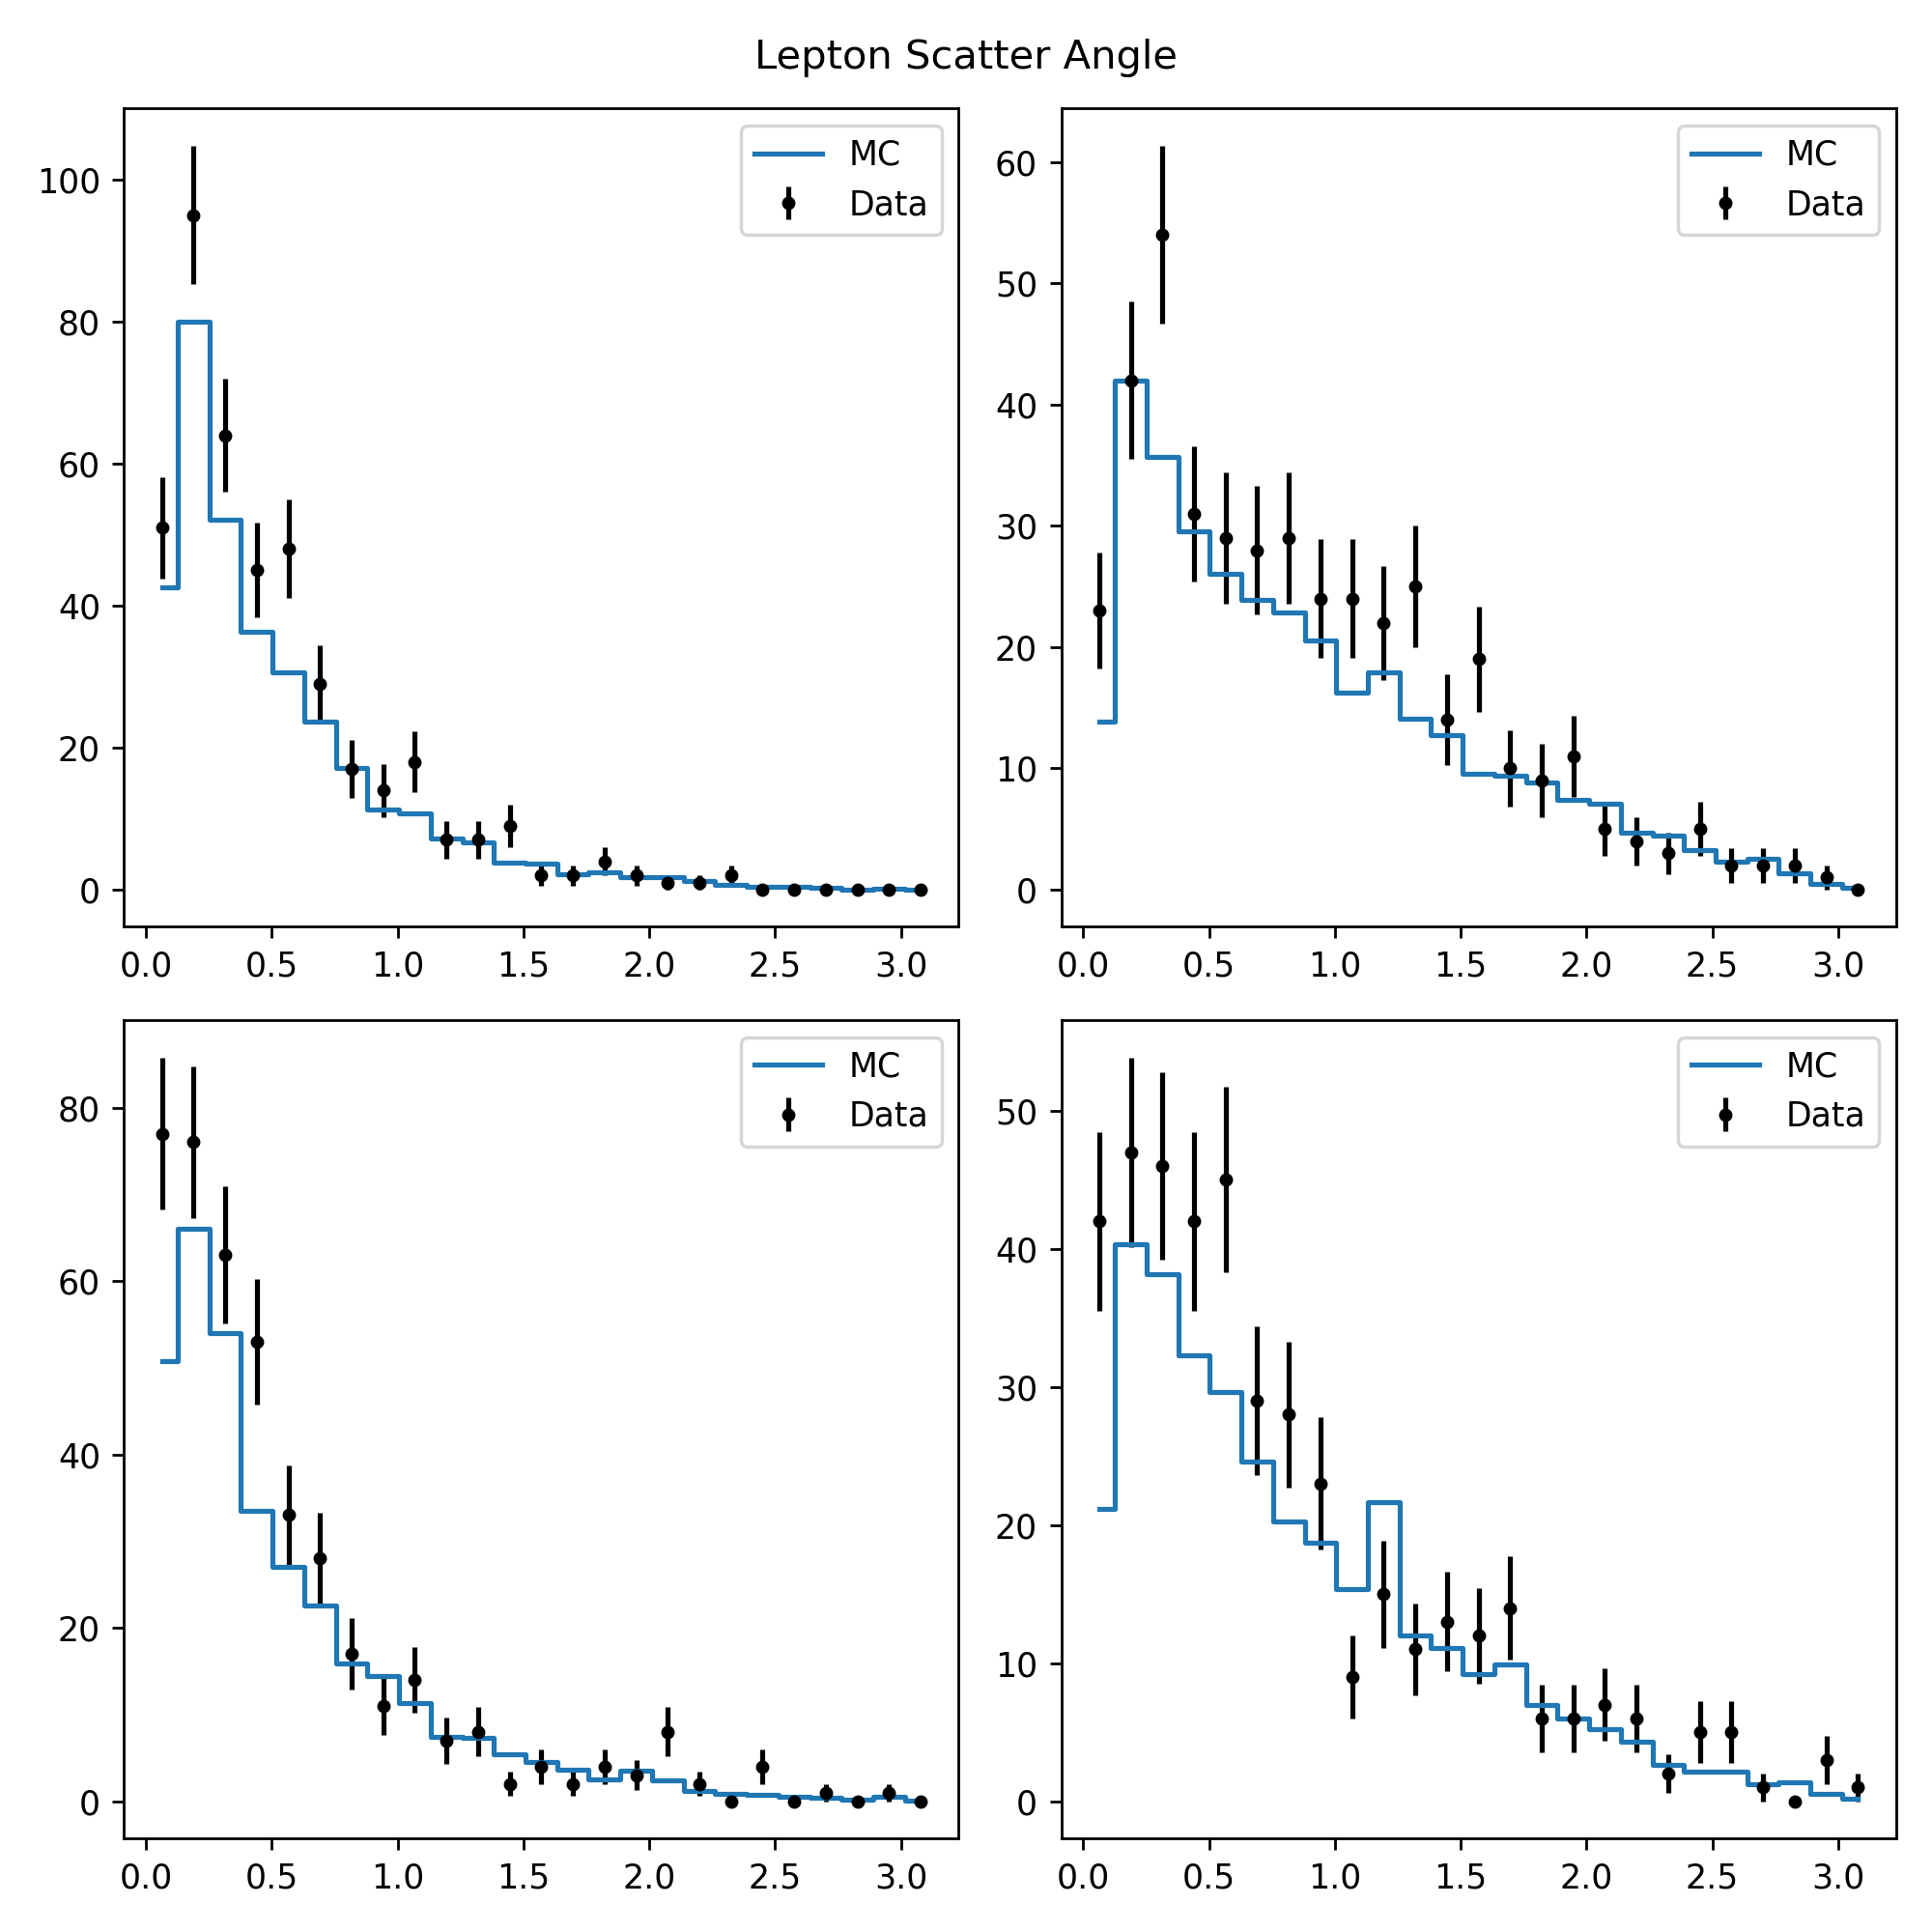

In [33]:
%matplotlib notebook
# lepton angles
nBins = 25
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for i, name in enumerate(['L0', 'L1', 'L2', 'L3']):
    name += ' a'
    for df, lab in zip([sim, dat], ['MC', 'Data']):
        counts, bins = np.histogram(df[name], bins=nBins, range=(0, pi), weights=df['w'])
        cents = ( bins[1:] + bins[:-1] ) / 2
        if lab == 'MC':
            ax[i//2, i%2].step(cents, counts, where='mid', label=lab)
        else:
            ax[i//2, i%2].errorbar(cents, counts, yerr=sqrt(counts), fmt='.k', label=lab)
        ax[i//2, i%2].legend()
plt.suptitle('Lepton Scatter Angle')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


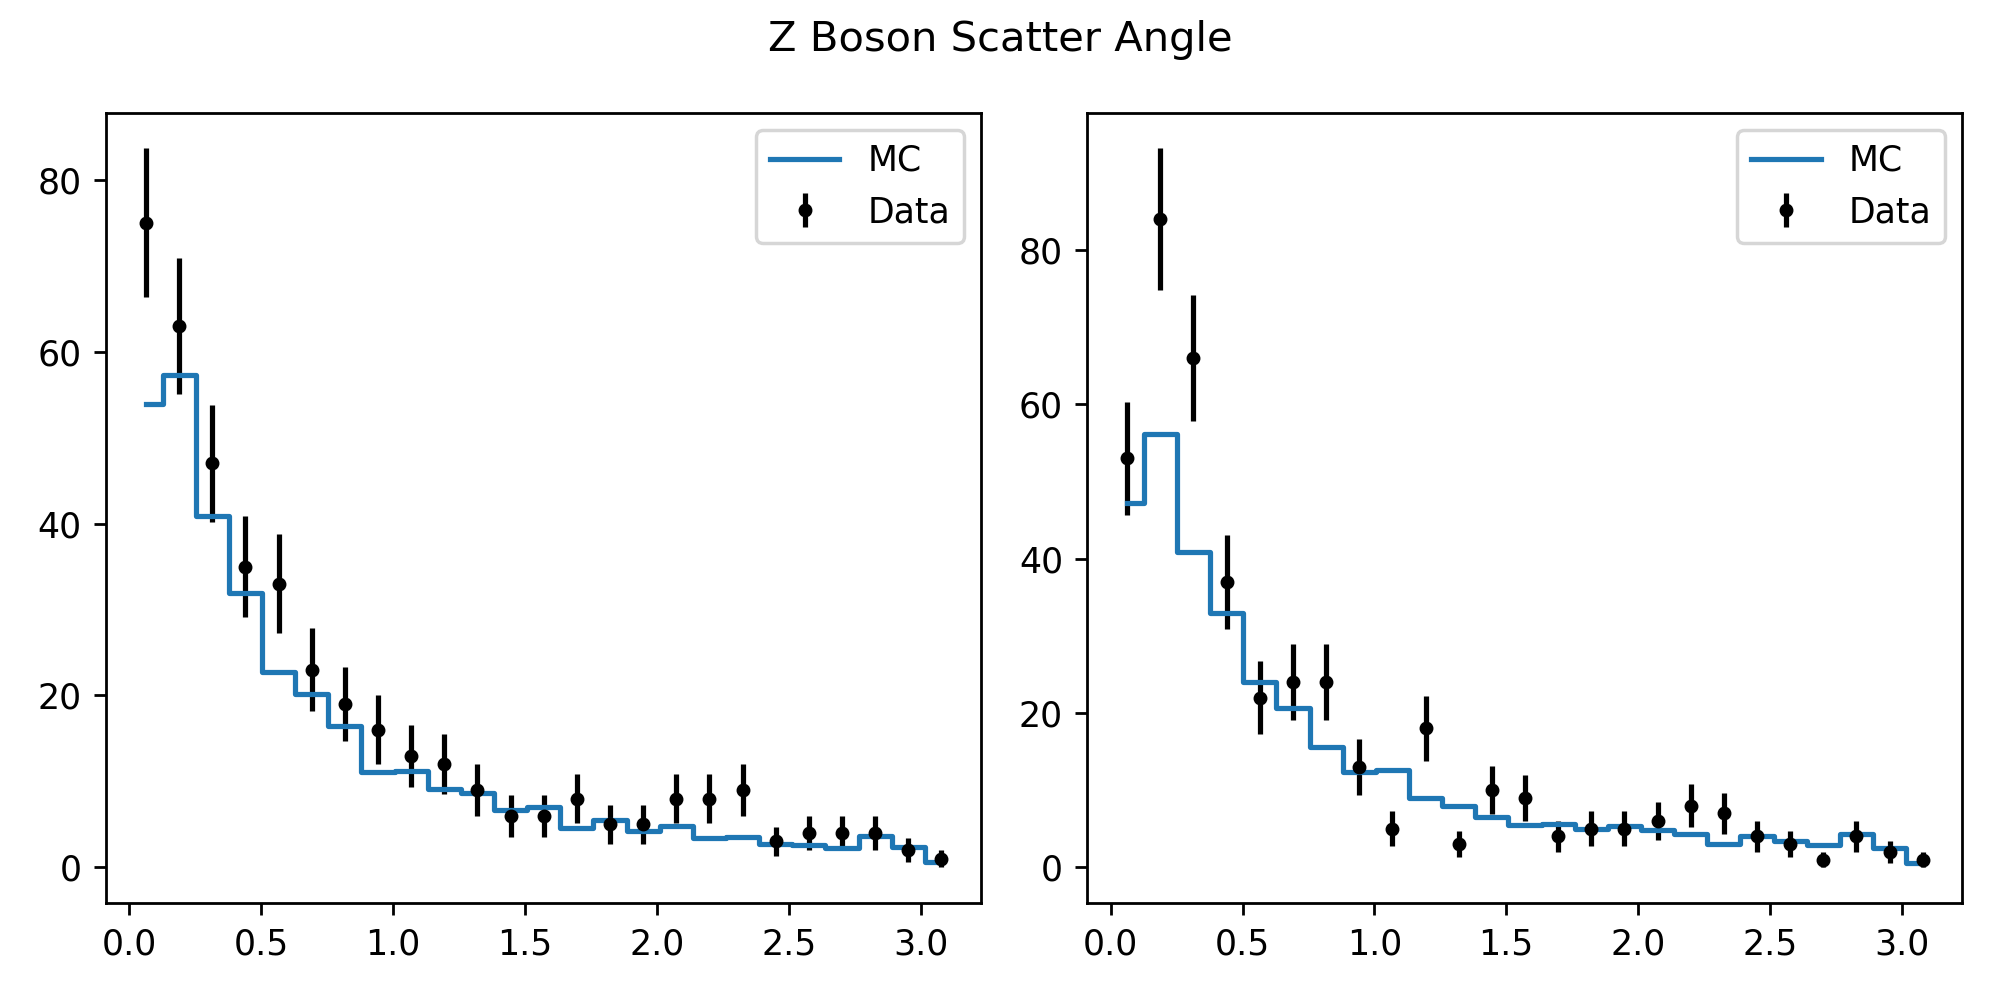

In [37]:
%matplotlib notebook
# Z angles
nBins = 25
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i, name in enumerate(['Z0', 'Z1']):
    name += ' a'
    for df, lab in zip([sim, dat], ['MC', 'Data']):
        counts, bins = np.histogram(df[name], bins=nBins, range=(0, pi), weights=df['w'])
        cents = ( bins[1:] + bins[:-1] ) / 2
        if lab == 'MC':
            ax[i].step(cents, counts, where='mid', label=lab)
        else:
            ax[i].errorbar(cents, counts, yerr=sqrt(counts), fmt='.k', label=lab)
        ax[i].legend()
plt.suptitle('Z Boson Scatter Angle')
plt.tight_layout()
plt.show()

# Ideas and General Notes
* **Ideas**
    * Compare angle distributions of eeuu subset to other subsets, as we have confidence over lepton pairing in eeuu
    * Compare angle as a function of other variables such as Z mass, H mass etc
* **Notes**
    * I will obviously improve the quality of the plots, and generate more. I can think of many combinations and comparisons which would be interesting to have a look at, this is just a proof of concept for now. 